## Load all packages and modules

In [1]:
import os,sys
import pyomo
import numpy as np
import pandas as pd
import geopandas as gpd
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.colors as colors

sys.path.append(os.path.join('..','src'))

from national_io import INDEC,GTAP,OECD,EORA
from mrio import estimate,prepare_table_mria
from mria import MRIA_IO as MRIA
from table import io_basic
from run_mria import run

data_path = os.path.join('..','data')


In [2]:
reg_mapper = {'Misiones' : 'Misiones', 
              'San Luis' : 'San_Luis',
              'San Juan' : 'San_Juan', 
              'Entre Rios' : 'Entre_Rios', 
              'Santa Cruz' :  'Santa_Cruz',
               'Rio Negro' : 'Rio_Negro', 
              'Chubut' : 'Chubut', 
              'Cordoba' : 'Cordoba', 
              'Mendoza' : 'Mendoza', 
              'La Rioja' : 'La_Rioja',
               'Catamarca' : 'Catamarca', 
              'La Pampa' : 'La_Pampa', 
              'Santiago del Estero' : 'Santiago_del_Estero', 
              'Corrientes' : 'Corrientes',
               'Santa Fe' : 'Santa_Fe',
              'Tucuman' : 'Tucuman',
              'Neuquen' : 'Neuquen', 
              'Salta' : 'Salta', 
              'Chaco' : 'Chaco', 
              'Formosa' : 'Formosa',
               'Jujuy' : 'Jujuy', 
              'Ciudad Autonoma de Buenos Aires' : 'Ciudad_de_Buenos_Aires', 
              'Buenos Aires' :  'Buenos_Aires',
               'Tierra del Fuego, Antartida e Islas del Atlantico Sur' : 'Tierra_del_Fuego'} 

In [3]:
inv_reg_mapper = {   'Misiones': 'Misiones',
                     'San_Luis': 'San Luis',
                     'San_Juan': 'San Juan',
                     'Entre_Rios': 'Entre Rios',
                     'Santa_Cruz': 'Santa Cruz',
                     'Rio_Negro': 'Rio Negro',
                     'Chubut': 'Chubut',
                     'Cordoba': 'Cordoba',
                     'Mendoza': 'Mendoza',
                     'La_Rioja': 'La Rioja',
                     'Catamarca': 'Catamarca',
                     'La_Pampa': 'La Pampa',
                     'Santiago_del_Estero': 'Santiago del Estero',
                     'Corrientes': 'Corrientes',
                     'Santa_Fe': 'Santa Fe',
                     'Tucuman': 'Tucuman',
                     'Neuquen': 'Neuquen',
                     'Salta': 'Salta',
                     'Chaco': 'Chaco',
                     'Formosa': 'Formosa',
                     'Jujuy': 'Jujuy',
                     'Ciudad_de_Buenos_Aires': 'Ciudad Autonoma \n de Buenos Aires',
                     'Buenos_Aires': 'Buenos Aires',
                     'Tierra_del_Fuego': 'Tierra del Fuego'}

## Create a dictioniary of the 2017 drought disruption

In [4]:
disr_dict_sup = {
        ('Buenos_Aires', 'A'):        1-0.13,
        ('Catamarca', 'A'):           1+0.31,
        ('Cordoba', 'A'):             1-0.23,
        ('Corrientes', 'A'):          1-0.11,
        ('Chaco', 'A'):               1-0.13,
        ('Entre_Rios', 'A'):          1-0.38,
        ('Formosa', 'A'):             1-0.65,
        ('Jujuy', 'A'):               1+0.02,
        ('La_Pampa', 'A'):            1-0.07,
        ('Misiones', 'A'):            1-0.11,
        ('Salta', 'A'):               1,
        ('San_Luis', 'A'):            1-0.35,
        ('Santa_Fe', 'A'):            1-0.17,
        ('Santiago_del_Estero', 'A'): 1-0.13,
        ('Tucuman', 'A'):             1+0.19}


## Run the model for all four data sources

In [5]:
data_sources = ['INDEC','OECD','EORA','GTAP']

In [6]:
%%time
all_outputs = {}
for data_source in data_sources:
    all_outputs[data_source] = run(data_source=data_source,set_year=2016,solver='IPOPT',disr_dict_sup=disr_dict_sup,print_output=False)

ok
INDEC_2016 results in -239.02788842230913 billion pesos losses for IPOPT
ok
OECD_2016 results in -335.7172101243714 billion pesos losses for IPOPT
ok
EORA_2016 results in -231.82008878778495 billion pesos losses for IPOPT
ok
GTAP_2016 results in -184.89778224628276 billion pesos losses for IPOPT
Wall time: 5min 57s


In [7]:
regions = ['Ciudad de Buenos Aires', 'Buenos Aires', 'Catamarca', 'Cordoba',
    'Corrientes', 'Chaco', 'Chubut', 'Entre Rios', 'Formosa', 'Jujuy',
    'La Pampa', 'La Rioja', 'Mendoza', 'Misiones', 'Neuquen', 'Rio Negro',
    'Salta', 'San Juan', 'San Luis', 'Santa Cruz', 'Santa Fe',
    'Santiago del Estero', 'Tucuman', 'Tierra del Fuego']

regions = [x.replace(' ','_') for x in regions]

prov_zones = gpd.read_file(os.path.join(data_path,'shapefiles','admin_1_boundaries.shp'))
ctry_zones = gpd.read_file(os.path.join(data_path,'shapefiles','admin_0_boundaries.shp'))
#prov_zones.name = prov_zones.name.apply(lambda x : reg_mapper[x])

In [8]:
prov_zones.name = prov_zones.name.str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8')
prov_zones.name = prov_zones.name.apply(lambda x : reg_mapper[x])
prov_zones.columns = ['region','geometry']

### Load province data

AttributeError: module 'matplotlib.colors' has no attribute 'DivergingNorm'

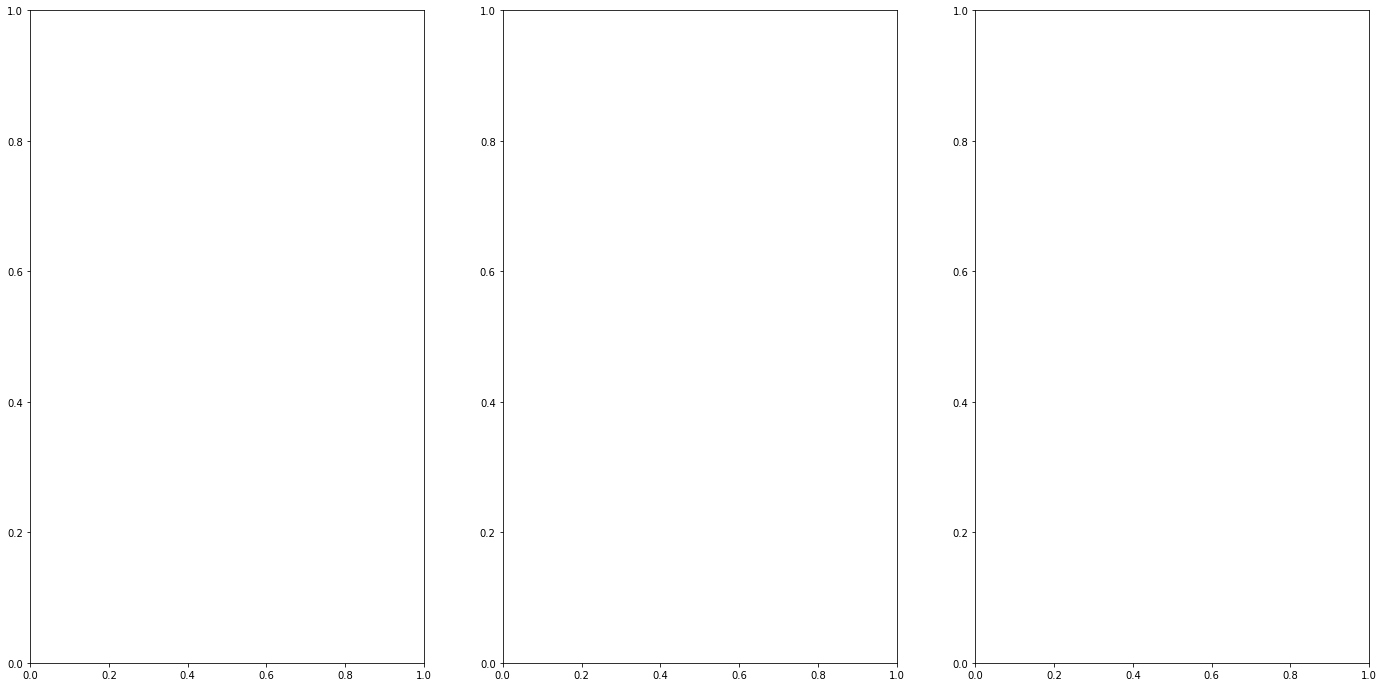

In [9]:
fig,axes =  plt.subplots(1,3,figsize=(24,12))

vmin, vmax, vcenter = -10, 2, 0
divnorm = colors.DivergingNorm(vmin=vmin, vcenter=0, vmax=vmax)
# create a normalized colorbar
cbar = plt.cm.ScalarMappable(norm=divnorm, cmap='RdYlGn')

variants = ['dir_losses','ind_losses','total_losses']
variant_names = ['Direct Impacts','Indirect Impacts','Total Impacts']
prov_plot = prov_zones.merge(all_outputs['INDEC'].sum(axis=0,level=0).reset_index(),left_on='region',right_on='region')
prov_plot = prov_plot.cx[-70:-55, -60:-20]
ctry_zones = ctry_zones.cx[-70:-55, -60:-20]

for iter_,ax in enumerate(axes.flat):
    ctry_zones.plot(ax=ax,edgecolor='white',color='#f1f2f4')
    prov_plot['rel_{}'.format(variants[iter_])] = (prov_plot[variants[iter_]]/prov_plot['x_in'])*100
    prov_plot.plot('rel_{}'.format(variants[iter_]),ax=ax,vmax=10,cmap='RdYlGn',legend=False,norm=divnorm)

    ax.set_ylim(-55,-20)
    ax.set_xlim(-75,-53)
    ax.set_title(variant_names[iter_],fontweight='bold',fontsize=22)
    ax.set_axis_off()    
    
    if iter_ == 2:
        cbax = fig.add_axes([0.95, 0.15, 0.02, 0.69])   
        cbax.set_title('Relative Impact')

        # blank-out the array of the scalar mappable 'sm'
        #cbar._A = []
        # draw colorbar into 'cbax'
        fig.colorbar(cbar, cax=cbax, format="%d")

plt.savefig(os.path.join('..','results','figures','INDEC_data_drought_impacts.png'),dpi=400,bbox_inches='tight')

In [ ]:
rel_tot_losses = {}
rel_dir_losses = {}
for data_source in data_sources:
    prov_impact = all_outputs[data_source].sum(axis=0,level=0)
    rel_tot_losses[data_source] = ((prov_impact['total_losses']/prov_impact['x_in'])*100)
    rel_dir_losses[data_source] = ((prov_impact['dir_losses']/prov_impact['x_in'])*100)
    
rel_dir_losses = pd.DataFrame(rel_dir_losses)
rel_tot_losses = pd.DataFrame(rel_tot_losses)

color_scheme = ['#26547c','#ef476f','#ffd166','#06d6a0'] 
data_sources = ['INDEC','OECD','GTAP','EORA']

color_lookup = dict(zip(data_sources,data_sources))

fig,axes =  plt.subplots(2,1,figsize=(24,12),sharex=True)

for iter_,ax in enumerate(axes.flat):
    if iter_ == 0:
        rel_dir_losses.plot(ax=ax,kind='bar', color=color_scheme)
    else:
        rel_tot_losses.index = rel_tot_losses.index.map(inv_reg_mapper)
        rel_tot_losses.plot(ax=ax,kind='bar', color=color_scheme)
        ax.set_xlabel('Region',fontsize=14,fontweight='bold')
        for tick in ax.get_xticklabels():
            tick.set_rotation(45)

    ax.set_ylabel('Loss in Production (in %)',fontsize=14,fontweight='bold')
    ax.get_yaxis().set_label_coords(-0.025,0.5)
    ax.set_facecolor('#FAF9F9')
    ax.spines['left'].set_color('black')
    ax.spines['bottom'].set_color('black')
    ax.tick_params(axis = 'both',labelsize=12,labelcolor='black',color='black')
    
plt.savefig(os.path.join('..','results','figures','loss_comparison_data_sources.png'),dpi=400,bbox_inches='tight')